In [1]:
import os
import pandas_datareader.data as pdr
import yfinance as yf
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
nifty100 = pd.read_csv("Downloads/ind_nifty100list.csv")

In [3]:
stock_list = list(nifty100['Symbol']+'.NS')

In [4]:
stock_data= []
for i in range(len(stock_list)):
    data = yf.download(tickers= stock_list[i], period='max', interval='1d')
    stock_data.append(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    """"#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)"""
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    

<Figure size 720x432 with 0 Axes>

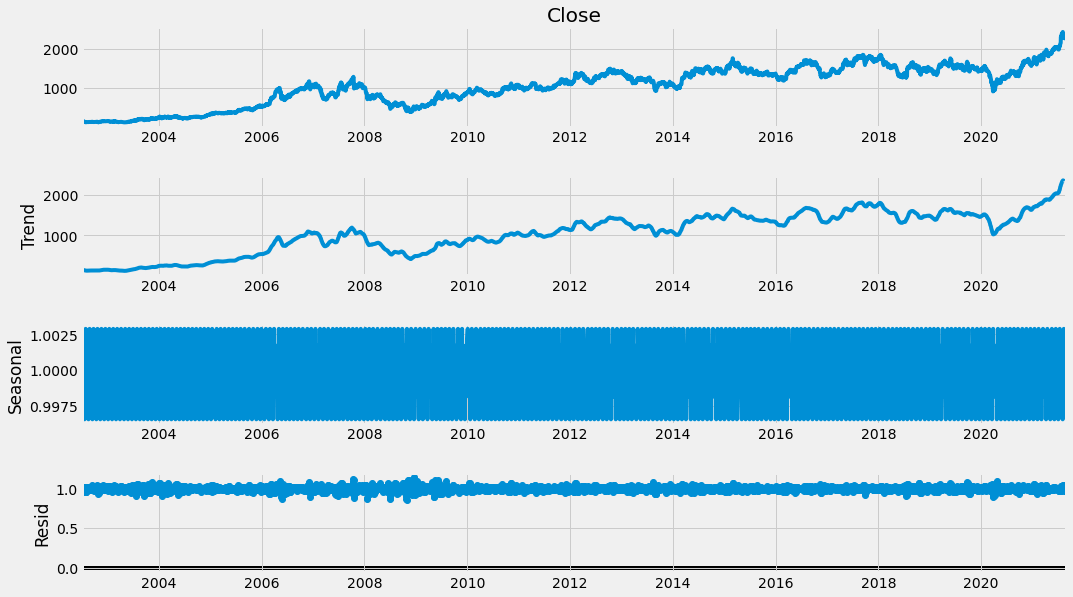

In [6]:
result = seasonal_decompose(stock_data[0]['Close'], model='multiplicative', freq = 20)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [7]:
# Index (Index can take value from 0-99 for selecting different stocks in NIFTY100)
index = 0
df_log = np.log(stock_data[index]['Close'])

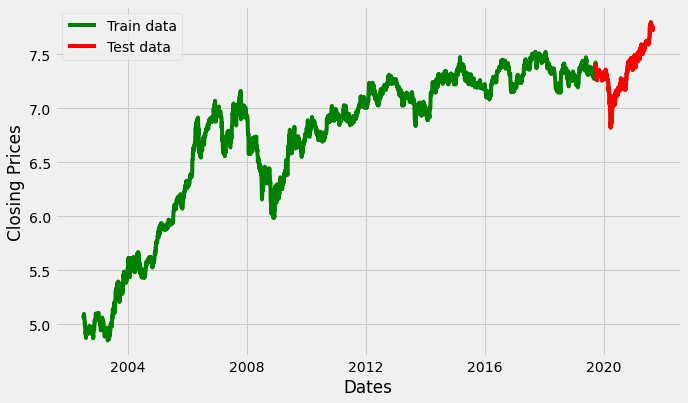

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,test='adf',max_p=3, max_q=3, m=1,d=None,seasonal=False,start_P=0,D=0,trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21224.238, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21227.348, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21227.545, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21223.080, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21226.393, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-21226.889, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-21225.277, Time=1.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-21226.603, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.587 seconds


In [14]:
#train_data.reset_index(inplace=True, drop=True)
model = ARIMA(train_data, order=(0, 1, 1))  

C:\Users\Naman Roshan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Naman Roshan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [15]:
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4274
Model:                 ARIMA(0, 1, 1)   Log Likelihood               10616.773
Method:                       css-mle   S.D. of innovations              0.020
Date:                Sun, 29 Aug 2021   AIC                         -21227.546
Time:                        20:54:50   BIC                         -21208.465
Sample:                             1   HQIC                        -21220.805
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.716      0.086   -7.79e-05       0.001
ma.L1.D.Close     0.0359      0.016      2.308      0.021       0.005       0.066
                                    Root

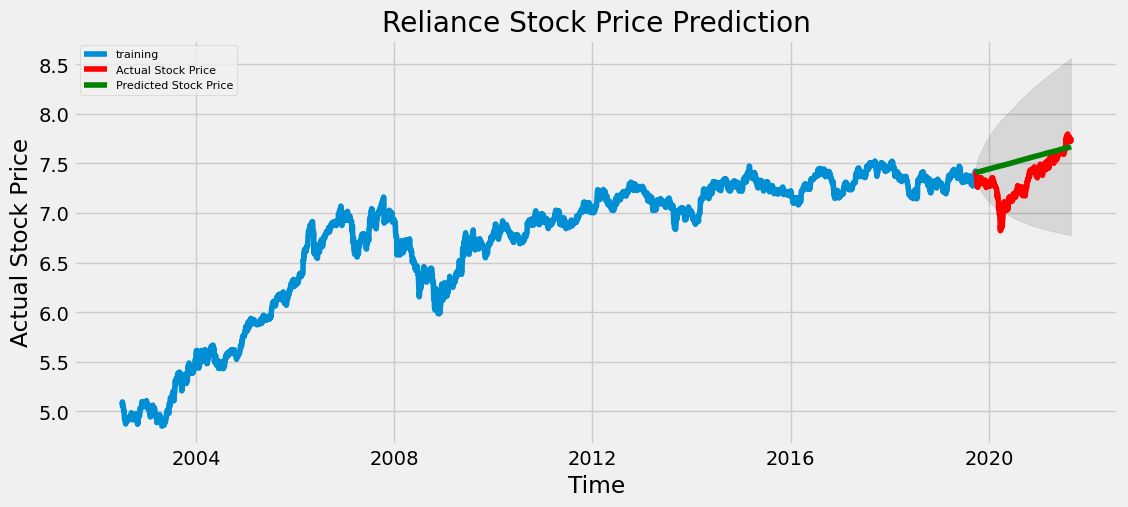

In [16]:
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'red', label='Actual Stock Price')
plt.plot(fc_series, color = 'green',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [17]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.056704486911144145
MAE: 0.19536873565328283
RMSE: 0.2381270394372385
MAPE: 0.02702949453858364
